In [ ]:
%reset

In [2]:
import geopandas as gpd
import xarray as xr
import numpy as np
import regionmask
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
import rioxarray as rio

In [3]:
path_ua = '/Users/nicoleta/Desktop/data/UA_SWE/'
files_ua = path_ua + '4km_SWE_Depth*.nc'
ds_ua = xr.open_mfdataset(files_ua)

In [4]:
def bounding_box(lower_left_longitude,
                 lower_left_latitude,
                 upper_right_longitude,
                 upper_right_latitude):
    #bb_array = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])
    bb_array = np.array([[lower_left_longitude, upper_right_latitude], [upper_right_longitude, upper_right_latitude], [upper_right_longitude, lower_left_latitude], [lower_left_longitude,  lower_left_latitude]])
    return bb_array




In [5]:
#Skagit_bb = [-122.6,48,-120,49.5]
#bb_array = np.array([[-122.6, 49.5], [-120, 49.5], [-120, 48], [-122.6, 48]])
Skagit_bb_array = bounding_box(-122.6, 47.8, -120, 49)
#Skagit_bb_array = bounding_box(-122.6,48,-120,49.5)
Skagit_bb_array

array([[-122.6,   49. ],
       [-120. ,   49. ],
       [-120. ,   47.8],
       [-122.6,   47.8]])

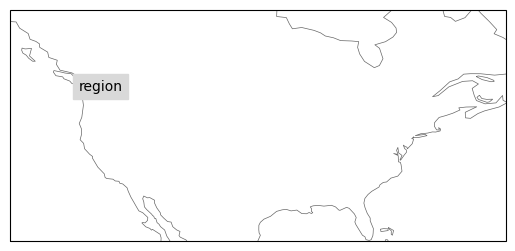

In [6]:
#US2 = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])

names = ["Skagit"]
abbrevs = ["region"]

bb_array = Skagit_bb_array

select_region = regionmask.Regions([bb_array], names=names, abbrevs=abbrevs, name="Skagit")

#region_poly = Polygon(bb_array)
ax = select_region.plot(label="abbrev")
# fine tune the extent
ax.set_extent([225, 300, 25, 60], crs=ccrs.PlateCarree())


In [7]:
#OSSEregions_poly = regionmask.Regions([region_poly])
#OSSEregions_poly
#mask_OSSE = OSSEregions_poly.mask(ds_ua)
mask_ = select_region.mask(ds_ua)
sel_mask = mask_.where(mask_ == 0).values
sel_mask
lat = mask_.lat.values
lon = mask_.lon.values
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
out_sel1 = ds_ua.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0],
                                                               id_lon[-1])).compute().where(mask_ == 0)


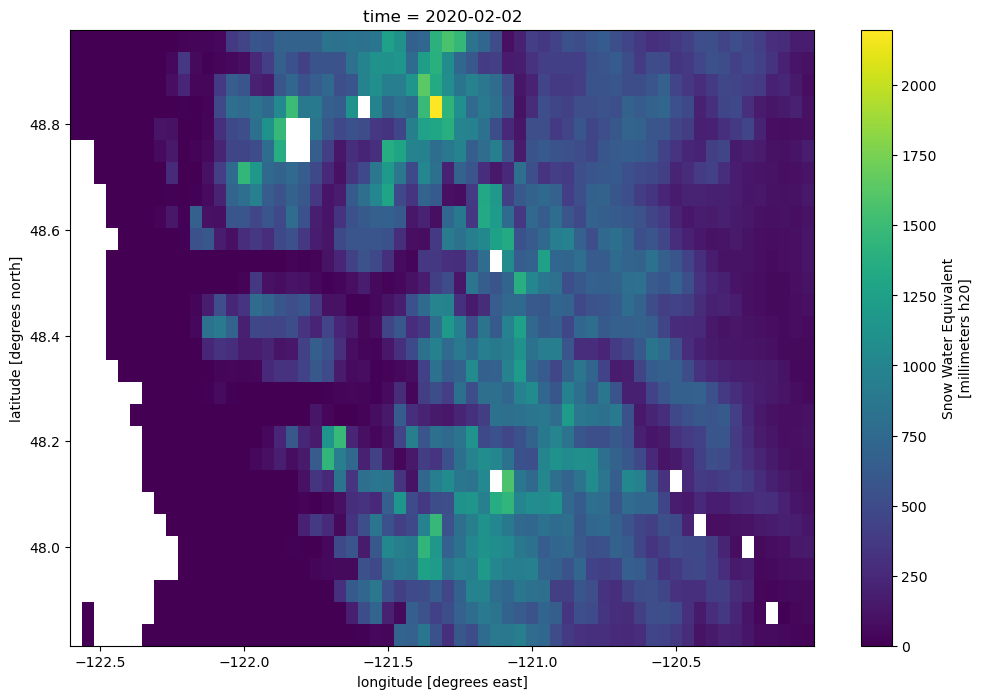

In [8]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
out_sel1.SWE.sel(time='2020-02-02').plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)


In [9]:
skagit_basin = gpd.read_file('/Users/nicoleta/Desktop/code/Compare_SWE/data/GIS_data/SkagitRiver_BasinBoundary.shp')
skagit_basin.head(3)

,OBJECTID,AREA,PERIMETER,SKAGIT_,SKAGIT_ID,GRID_CODE,Shape_Leng,Shape_Area,geometry
0,1,8.060220e+09,948300.0,2,1,1,948300.0,8.060220e+09,"POLYGON ((-120.81726 49.26101, -120.81520 49.2..."
1,2,2.250000e+04,600.0,3,2,1,600.0,2.250000e+04,"POLYGON ((-121.29579 48.95465, -121.29784 48.9..."


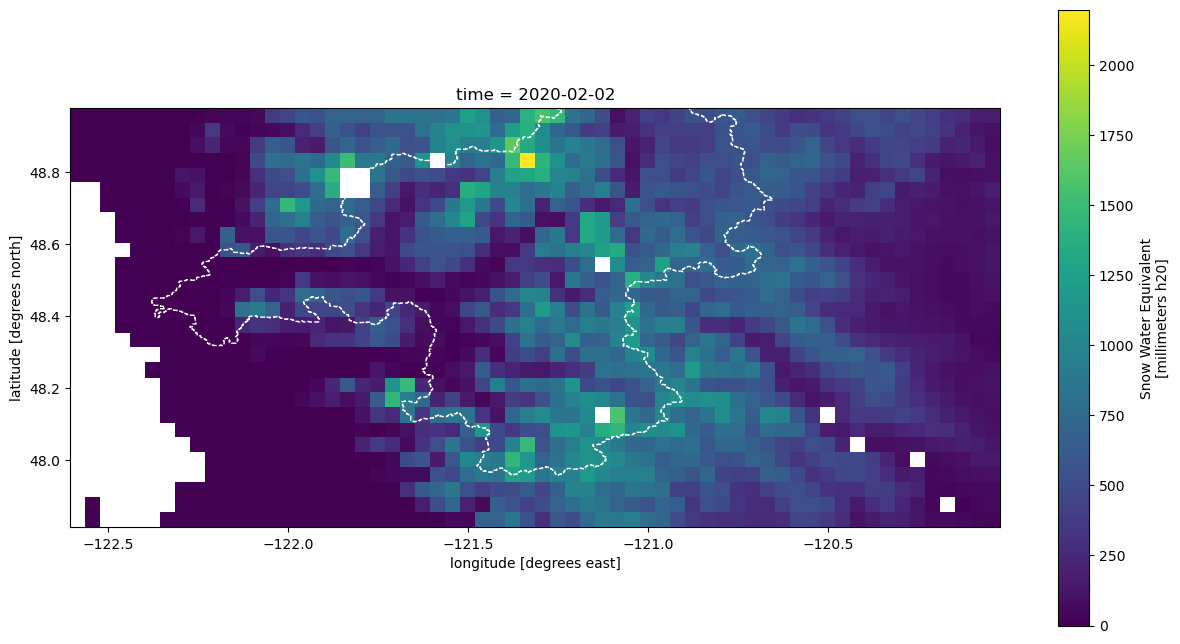

In [10]:
fig, ax = plt.subplots(figsize=(15,8))

one_day = out_sel1.SWE.sel(time='2020-02-02')
one_day.plot(ax=ax)

skagit_basin.plot(ax=ax, edgecolor='white', linestyle='--', facecolor='none');

ax.set_aspect(1)

In [13]:
one_day = one_day.to_crs(skagit_basin.crs)

AttributeError: 'DataArray' object has no attribute 'to_crs'

In [12]:
skagit_one_day = one_day.rio.clip(skagit_basin.geometry.apply(mapping),crs = skagit_basin.crs)


MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: SWE